In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

/home/julien/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 55)

In [3]:
#read in csv
df = pd.read_csv("bigtable.csv")

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]#.astype(np.float64)

df = pd.read_csv("bigtable.csv")
df = clean_dataset(df).reset_index()

features = df[[
    'population', 
    'dist-mroads', 
    'dist-setl', 
    'dist-coast', 
    'dist-forest', 
    'slope', 
    'elevation', 
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'Wind-Dir', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

#features.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

gs = df[['station_id']]

labels = df[[
    'pm25',
    'AQI_VALUE', #pm25 transformed using EPA methodology
    'AQI_class'  #pm25 transformed into EPA categorical class
]]

labels.loc[:,"polluted"] = (labels["AQI_class"] != "Good")

y=labels["polluted"]
X=features
X['dayofweek']

/home/julien/.local/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/julien/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


0         2.0
1         3.0
2         3.0
3         3.0
4         3.0
         ... 
105219    6.0
105220    6.0
105221    6.0
105222    6.0
105223    6.0
Name: dayofweek, Length: 105224, dtype: float64

In [5]:
dict(features.dtypes)

{'population': dtype('float64'),
 'dist-mroads': dtype('float64'),
 'dist-setl': dtype('float64'),
 'dist-coast': dtype('float64'),
 'dist-forest': dtype('float64'),
 'slope': dtype('float64'),
 'elevation': dtype('float64'),
 'dayofweek': dtype('float64'),
 'sin_day': dtype('float64'),
 'cos_day': dtype('float64'),
 'sin_year': dtype('float64'),
 'cos_year': dtype('float64'),
 'TEMP': dtype('float64'),
 'Wind-Dir': dtype('float64'),
 'Wind-Rate': dtype('float64'),
 'DEW': dtype('float64'),
 'SKY': dtype('float64'),
 'VIS': dtype('float64'),
 'ATM': dtype('float64')}

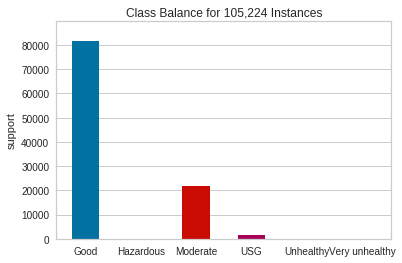

In [6]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(
    #labels=["Good", "USG", "Moderate", "Unhealthy", "Very unhealthy", "Hazardous"], size=(1080, 720)
)

visualizer.fit(df['AQI_class'].values)
visualizer.show()

In [7]:
df['AQI_class'].value_counts


<bound method IndexOpsMixin.value_counts of 0          USG
1          USG
2         Good
3         Good
4         Good
          ... 
105219    Good
105220    Good
105221    Good
105222    Good
105223    Good
Name: AQI_class, Length: 105224, dtype: object>

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object','category']).columns


numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='constant')),
('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

categorical_features

Index([], dtype='object')

In [9]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
     ('preprocessor', StandardScaler()),
     ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [10]:
# Try them all! Looking for Pokemons

models = [
    SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]


for model in models:
    score_model(X, y, model)

SVC: 0.552342596321654
KNeighborsClassifier: 0.8046927374301676
LogisticRegression: 0.30742049469964666
BaggingClassifier: 0.9531934911369127
ExtraTreesClassifier: 0.955900089910309
RandomForestClassifier: 0.9569332905021951


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


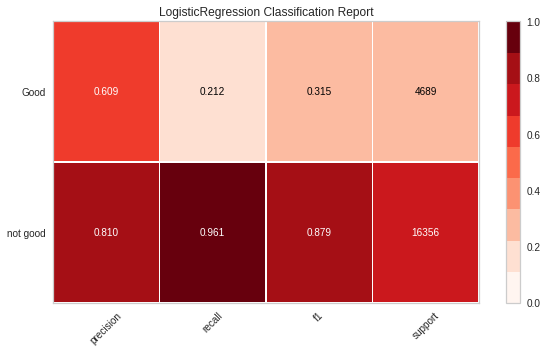

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


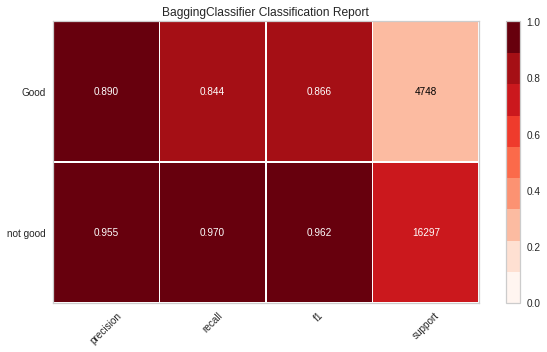

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


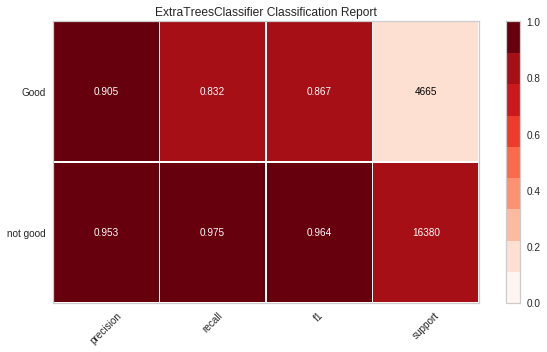

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


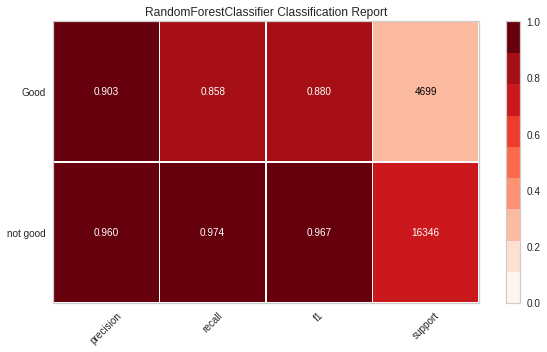

In [11]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)

    model = Pipeline([
     ('preprocessor', StandardScaler()),
     ('estimator', estimator)
    ])
    
#    model = Pipeline([
#         ('one_hot_encoder', OneHotEncoder()), 
#         ('estimator', estimator)
#    ])
    
    visualizer = ClassificationReport(
        model, 
        classes=['not good', 'Good'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)
    
    visualizer.score(X_test, y_test)
    
    visualizer.show()  
  

    
#keeping best ones
models = [
    #SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    #KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    visualize_model(X, y, model)
    


In [12]:
X[np.isclose(X["cos_year"], -0.1099)]

,population,dist-mroads,dist-setl,dist-coast,dist-forest,slope,elevation,dayofweek,sin_day,cos_day,sin_year,cos_year,TEMP,Wind-Dir,Wind-Rate,DEW,SKY,VIS,ATM


# To avoid or detect overfitting to groundstations conditions (too few ground stations)

Let s shuffle Training and test data based on Groundstations id

Only 13 stations, so let's use 10 for training and 3 for testing.


2.6
Test substations selected: 
['14th & S ST NW B', 'Arlington']


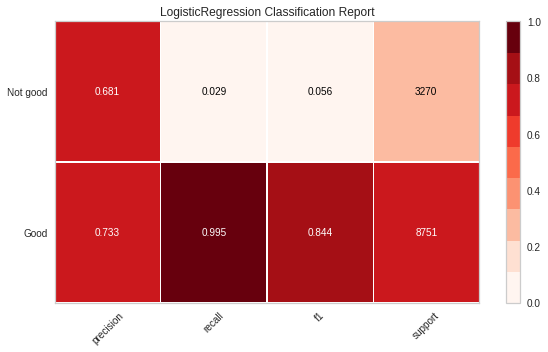

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


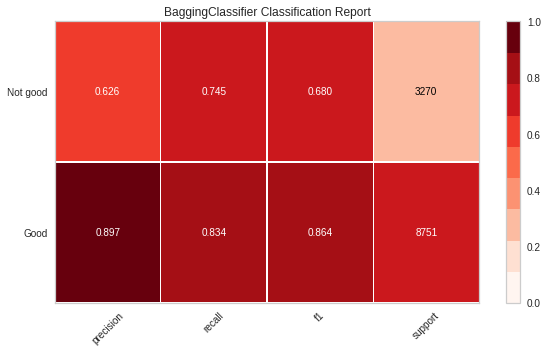

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


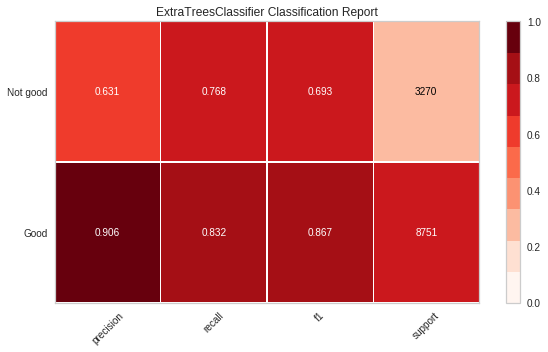

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


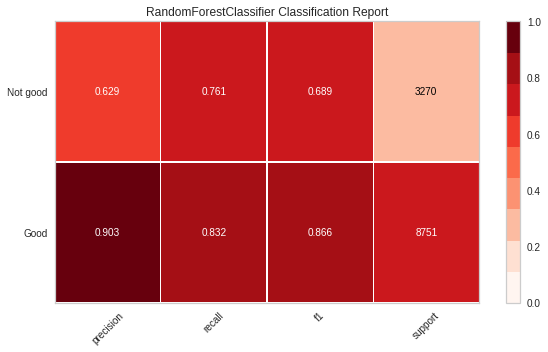

In [67]:
import random

def tts_gs(X, y, gs, test_size):
    stations = gs["station_id"].unique()
    nb_stations = len(stations) * test_size
    print(nb_stations)
    my_randoms = random.sample(list(stations), int(nb_stations))
    filters = gs["station_id"].isin(my_randoms)
    print('Test substations selected: ')
    print(my_randoms)
    return X[~filters], X[filters], y[~filters], y[filters]


def visualize_model_gs(X_train, X_test, y_train, y_test, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    y_train = LabelEncoder().fit_transform(y_train)
    y_test = LabelEncoder().fit_transform(y_test)
    
    model = Pipeline([
     ('preprocessor', StandardScaler()),
     ('estimator', estimator)
    ])


    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Good', 'Not good'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    #X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    #import pdb; pdb.set_trace()
    visualizer.fit(X_train, y_train)  
    score = visualizer.score(X_test, y_test)
    visualizer.show()
    return score

X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    
for model in models:
    visualize_model_gs(X_train, X_test, y_train, y_test, model)

In [14]:
#Let's remove all x/y features and keep just "postion in decimal degrees"
features_noGIS = df[[
    'x',
    'y',
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
    'TEMP', 
    'Wind-Dir', 
    'Wind-Rate', 
    'DEW', 
    'SKY', 
    'VIS', 
    'ATM'
]].astype(np.float64)

#features_noGIS.loc[:,'dayofweek'] = features['dayofweek'].astype('category')

X=features_noGIS
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


models = [
    #SVC(gamma='auto'),
    # NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), 
    #KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

2.6
Test substations selected: 
['Courthouse', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=District of Columbia - Department of Energy and Environment, url=null}]']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


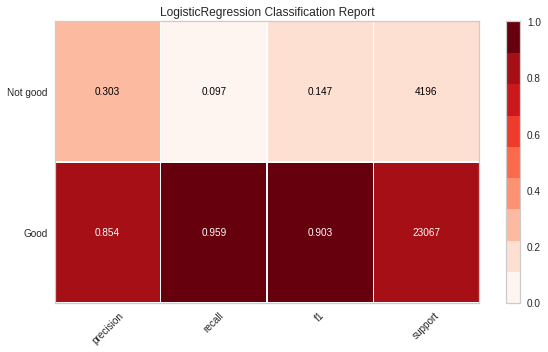

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


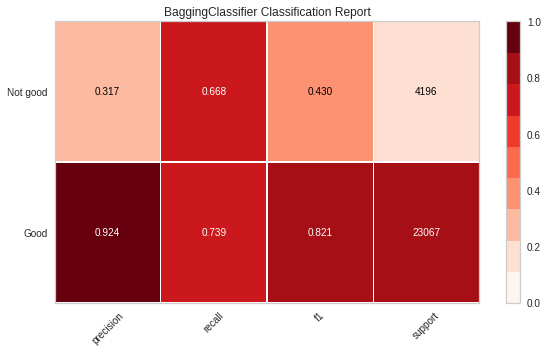

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


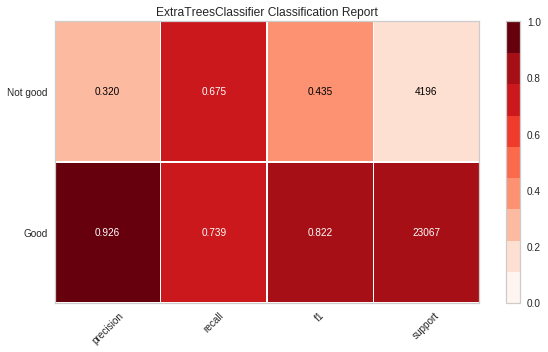

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


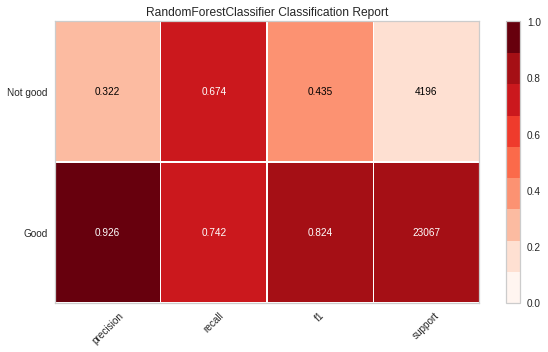

In [16]:
X_train, X_test, y_train, y_test = tts_gs(X, y, gs, test_size=0.20)
    
for model in models:
    visualize_model_gs(X_train, X_test, y_train, y_test, model)

Test substations selected: 
['13th & E ST SE B', '13th & E ST SE A', '14th & S ST NW B']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


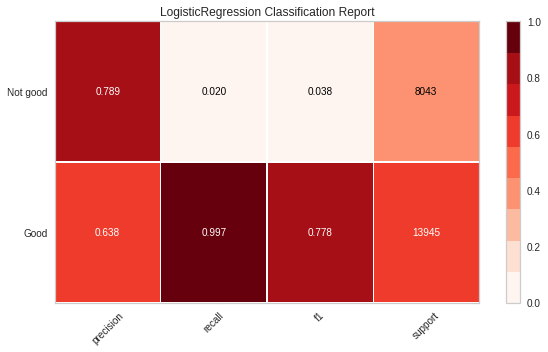

 > Score 0.639439694378752
Test substations selected: 
['Cheverly 1', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=District of Columbia - Department of Energy and Environment, url=null}]', '14th & S ST NW A']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


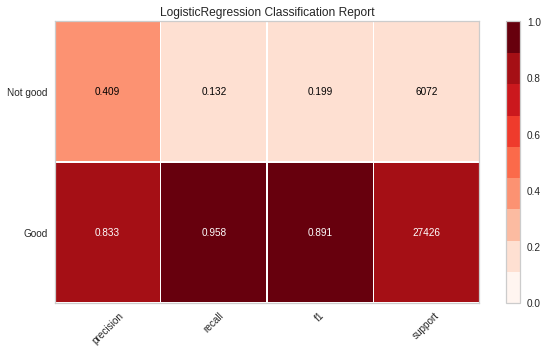

 > Score 0.8081377992715983
Test substations selected: 
['Arlington', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=Maryland Department of the Environment, url=null}]', 'Cheverly 9']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


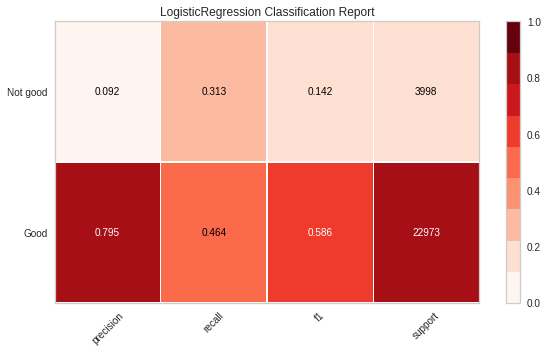

 > Score 0.44121463794445887
Test substations selected: 
['Courthouse', 'McMillan 1']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


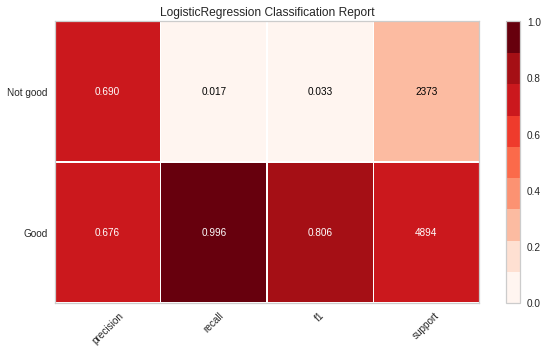

 > Score 0.6764827301499932
Test substations selected: 
['[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=Virginia Dept. of Environmental Quality, url=null}]', 'V Street']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


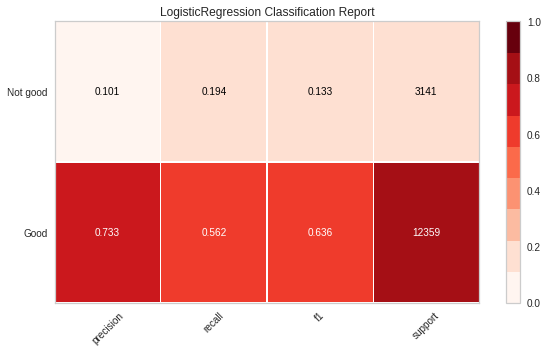

 > Score 0.4870967741935484
 >> Mean score 0.6104743271876701
['LogisticRegression', 0.639439694378752, 0.8081377992715983, 0.44121463794445887, 0.6764827301499932, 0.4870967741935484, 0.01762756258799005, 0.6104743271876701]
Test substations selected: 
['13th & E ST SE B', '13th & E ST SE A', '14th & S ST NW B']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


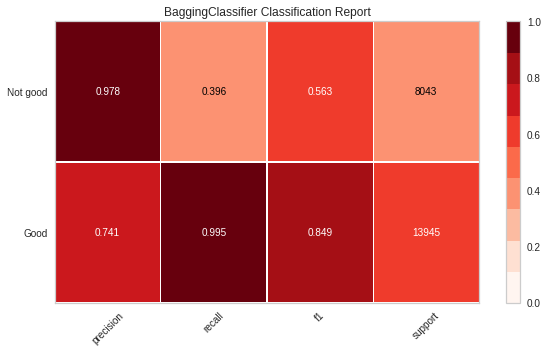

 > Score 0.7757413134436966
Test substations selected: 
['Cheverly 1', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=District of Columbia - Department of Energy and Environment, url=null}]', '14th & S ST NW A']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


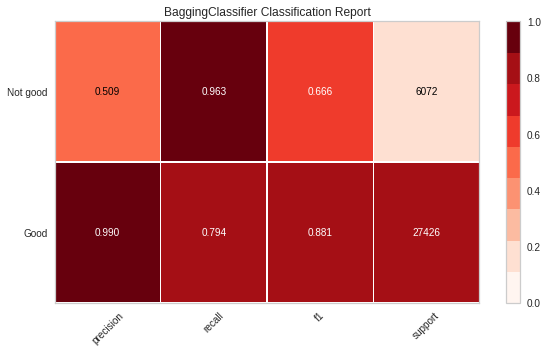

 > Score 0.824765657651203
Test substations selected: 
['Arlington', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=Maryland Department of the Environment, url=null}]', 'Cheverly 9']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


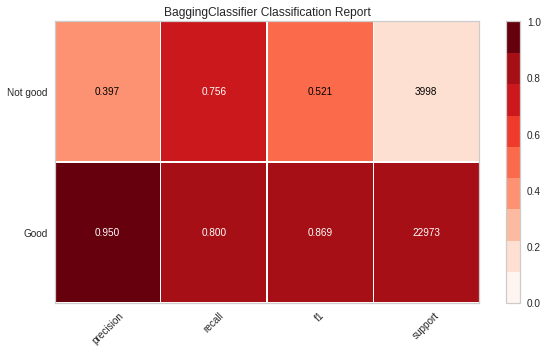

 > Score 0.793630195395054
Test substations selected: 
['Courthouse', 'McMillan 1']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


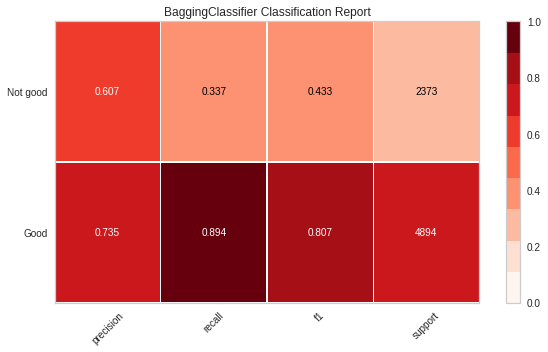

 > Score 0.7121232970964635
Test substations selected: 
['[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=Virginia Dept. of Environmental Quality, url=null}]', 'V Street']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


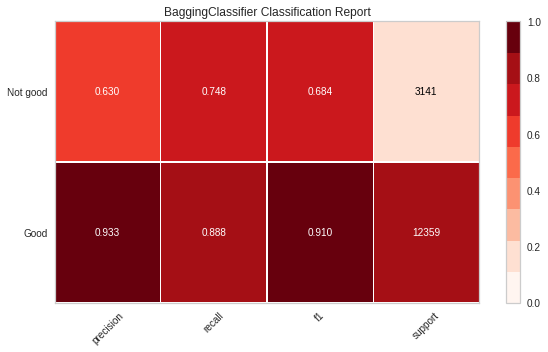

 > Score 0.8598709677419355
 >> Mean score 0.7932262862656705
['BaggingClassifier', 0.7757413134436966, 0.824765657651203, 0.793630195395054, 0.7121232970964635, 0.8598709677419355, 0.0024639655571635686, 0.7932262862656705]
Test substations selected: 
['13th & E ST SE B', '13th & E ST SE A', '14th & S ST NW B']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


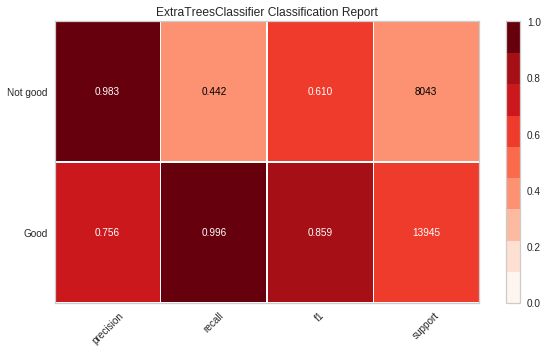

 > Score 0.7932053847553211
Test substations selected: 
['Cheverly 1', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=District of Columbia - Department of Energy and Environment, url=null}]', '14th & S ST NW A']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


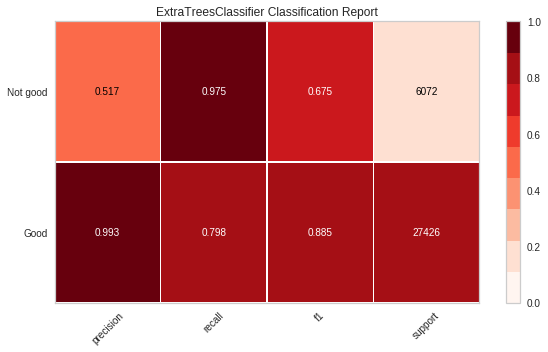

 > Score 0.8301391127828527
Test substations selected: 
['Arlington', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=Maryland Department of the Environment, url=null}]', 'Cheverly 9']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


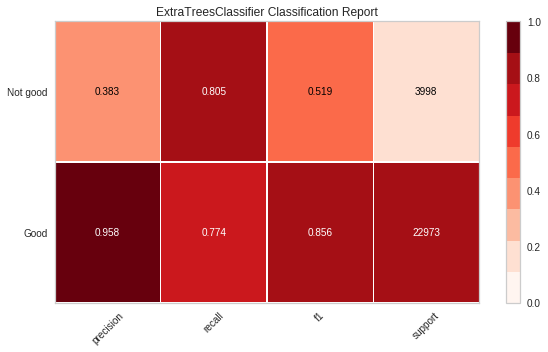

 > Score 0.7786140669608097
Test substations selected: 
['Courthouse', 'McMillan 1']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


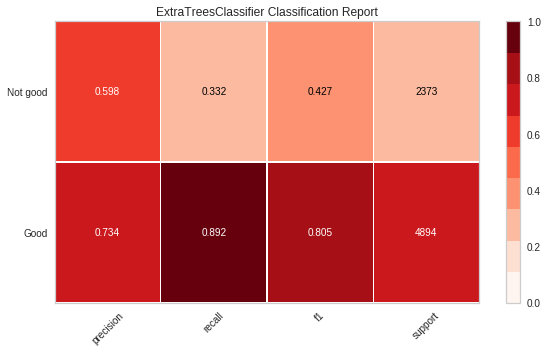

 > Score 0.7090959130315123
Test substations selected: 
['[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=Virginia Dept. of Environmental Quality, url=null}]', 'V Street']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


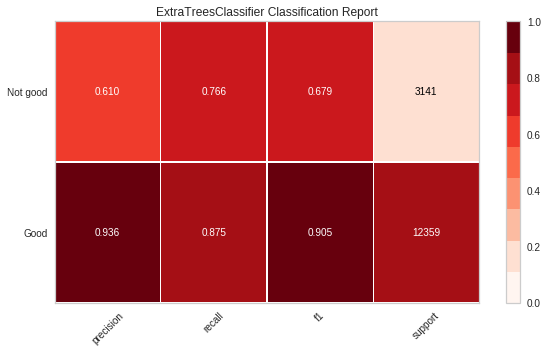

 > Score 0.8531612903225806
 >> Mean score 0.7928431535706152
['ExtraTreesClassifier', 0.7932053847553211, 0.8301391127828527, 0.7786140669608097, 0.7090959130315123, 0.8531612903225806, 0.0024490929219769114, 0.7928431535706152]
Test substations selected: 
['13th & E ST SE B', '13th & E ST SE A', '14th & S ST NW B']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


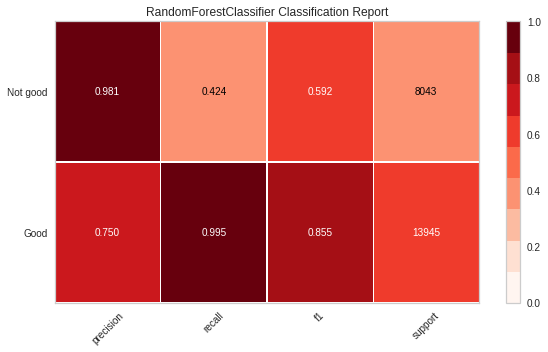

 > Score 0.7864289612515918
Test substations selected: 
['Cheverly 1', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=District of Columbia - Department of Energy and Environment, url=null}]', '14th & S ST NW A']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


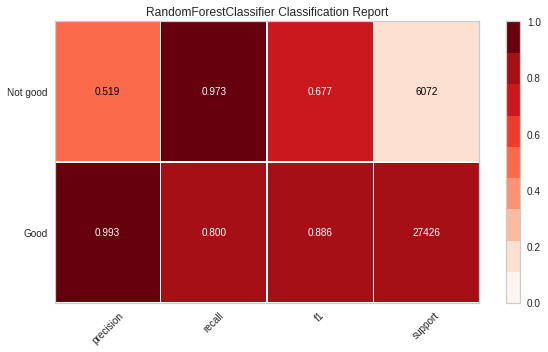

 > Score 0.831810854379366
Test substations selected: 
['Arlington', '[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=Maryland Department of the Environment, url=null}]', 'Cheverly 9']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


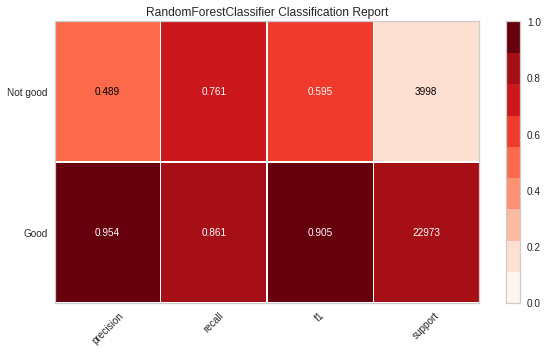

 > Score 0.8466130288087205
Test substations selected: 
['Courthouse', 'McMillan 1']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


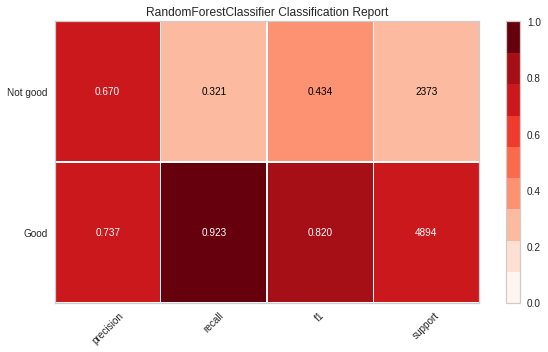

 > Score 0.7265721755882758
Test substations selected: 
['[{name=US EPA AirNow, url=http://www.airnow.gov/}, {name=Virginia Dept. of Environmental Quality, url=null}]', 'V Street']


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


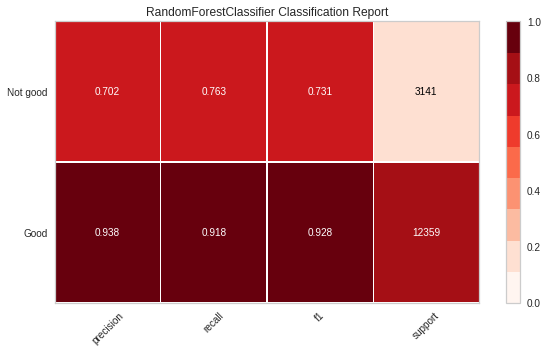

 > Score 0.8861935483870967
 >> Mean score 0.8155237136830102
['RandomForestClassifier', 0.7864289612515918, 0.831810854379366, 0.8466130288087205, 0.7265721755882758, 0.8861935483870967, 0.0029969845505232067, 0.8155237136830102]


In [76]:
import random

X=features_noGIS
y=labels["polluted"]


def tts_grps(X, y, groups):
    filters = gs["station_id"].isin(groups)
    print('Test substations selected: ')
    print(groups)
    return X[~filters], X[filters], y[~filters], y[filters]
    

stations = list(gs["station_id"].unique())
stations_groups = [[], [], [], [], []]

totStations = len(stations)
for i in range(totStations):
    random_item_from_list = random.choice(stations)
    stations.remove(random_item_from_list)
    stations_groups[i % 5].append(random_item_from_list)

dfScores = pd.DataFrame(
    columns = ['model', 'group1', 'group2', 'group3', 'group4', 'group5', 'Var', 'Mean']
)

for model in models:
    scores = []
    for groups in stations_groups:
        X_train, X_test, y_train, y_test = tts_grps(X, y, groups)
        score = visualize_model_gs(X_train, X_test, y_train, y_test, model)
        print(" > Score {}".format(score))
        scores.append(score)
    print(" >> Mean score {}".format(sum(scores) / len(stations_groups)))
    mean = sum(scores) / len(stations_groups)
    scores.append(sum((i - mean) ** 2 for i in scores) / len(scores))
    scores.append(mean)
    scores.insert(0, str(model).split("(")[0])
    print(scores)
    dfScores.loc[len(dfScores)] = scores

In [77]:
dfScores.head(7)

,model,group1,group2,group3,group4,group5,Var,Mean
0,LogisticRegression,0.639440,0.808138,0.441215,0.676483,0.487097,0.017628,0.610474
1,BaggingClassifier,0.775741,0.824766,0.793630,0.712123,0.859871,0.002464,0.793226
2,ExtraTreesClassifier,0.793205,0.830139,0.778614,0.709096,0.853161,0.002449,0.792843
3,RandomForestClassifier,0.786429,0.831811,0.846613,0.726572,0.886194,0.002997,0.815524


# RandomForestClassifier is the best with a mean score of 0.815 con Var of 0.003